# 10 - Segmentation and Pose Estimation with Ultralytics YOLO

In this notebook we go beyond bounding boxes and explore two advanced vision tasks supported by Ultralytics YOLO models:
- **Instance segmentation** (pixel-level object masks)
- **Pose estimation** (keypoints on human bodies)

We will use the same YOLO11 family of models and the example images downloaded in the Ultralytics introduction notebook.

## Table of Contents

1. [Setup and Models](#Setup-and-Models)
2. [What Is Instance Segmentation?](#What-Is-Instance-Segmentation?)
3. [Segmentation with YOLO11](#Segmentation-with-YOLO11)
4. [Binary Masks and Pixel Operations](#Binary-Masks-and-Pixel-Operations)
5. [Exercise: Pixelate a Person Using a Segmentation Mask](#Exercise-Pixelate-a-Person-Using-a-Segmentation-Mask)
6. [What Is Pose Estimation?](#What-Is-Pose-Estimation?)
7. [Pose Estimation with YOLO11](#Pose-Estimation-with-YOLO11)
8. [Exercise: Explore Keypoints on Yoga Images](#Exercise-Explore-Keypoints-on-Yoga-Images)
9. [Recap](#Recap)

## Setup and Models

Let's import the necessary libraries. Make sure to run `07_intro_to_ultralytics.ipynb` first to download the example images.

In [1]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

# Check that images are available
if not os.path.exists("../images"):
    print("Warning: ../images/ not found. Run 07_intro_to_ultralytics.ipynb first to download example images.")
else:
    print("Images directory found. Ready to proceed.")

Images directory found. Ready to proceed.


## What Is Instance Segmentation?

Instance segmentation combines object detection with semantic segmentation. Instead of just drawing a bounding box around an object, it identifies the exact pixels that belong to each object instance.

### Detection vs. Segmentation

- **Object Detection**: Outputs bounding boxes (rectangles) around objects
  - Fast and efficient
  - Good for counting and localization
  - Less precise (includes background pixels)

- **Instance Segmentation**: Outputs pixel-level masks for each object
  - More computationally expensive
  - Precise object boundaries
  - Useful for applications requiring exact shapes (medical imaging, video editing)

### Semantic vs. Instance Segmentation

- **Semantic Segmentation**: Labels every pixel with a class (all cars are "car")
- **Instance Segmentation**: Distinguishes between different instances of the same class (car #1, car #2, etc.)

YOLO models with the `-seg` suffix perform instance segmentation.

## Segmentation with YOLO11

Let's load a segmentation model and run it on one of our example images.

In [2]:
# Load YOLO11 segmentation model (nano version)
seg_model = YOLO("yolo11n-seg.pt")

print(f"Segmentation model loaded: {seg_model.model_name}")

Segmentation model loaded: yolo11n-seg.pt



0: 384x640 1 person, 5 cars, 3 buss, 89.1ms
Speed: 1.4ms preprocess, 89.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


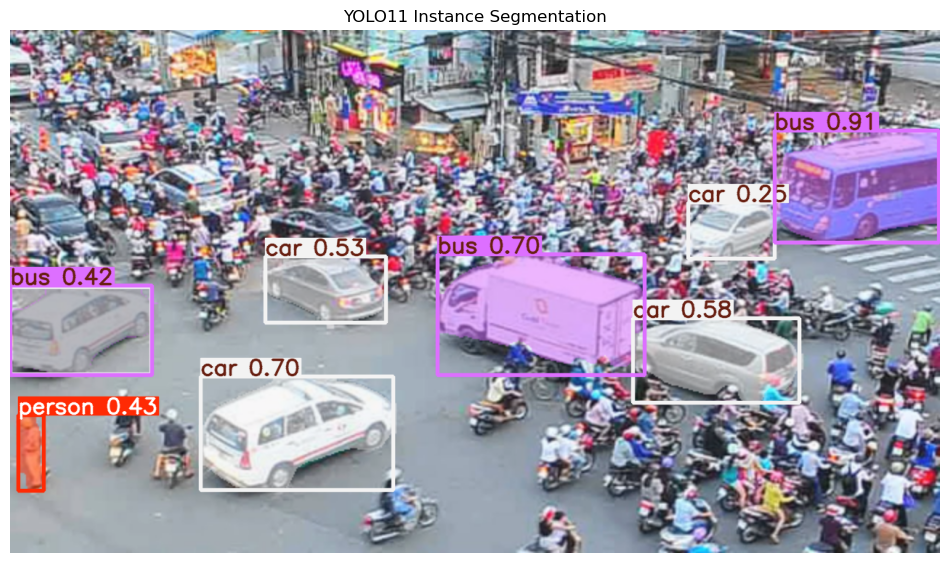

In [3]:
# Run segmentation on a traffic image
image_path = "../images/yolo_traffic.jpg"
img_bgr = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

results = seg_model(img_rgb)
result = results[0]
annotated = result.plot()

plt.figure(figsize=(12, 7))
plt.imshow(annotated)
plt.title("YOLO11 Instance Segmentation")
plt.axis("off")
plt.show()

**What we see:**

- Colored masks showing the exact shape of each object
- Different colors for different instances (even of the same class)
- Bounding boxes and class labels overlaid on the masks
- Much more precise than simple rectangles

In [4]:
# Inspect the segmentation results
print("Segmentation results structure:")
print(f"  Number of detected objects: {len(result.boxes)}")
print(f"  Masks available: {result.masks is not None}")

if result.masks is not None:
    print(f"  Number of masks: {len(result.masks)}")
    print(f"  Mask data shape: {result.masks.data.shape}")

# List detected objects
print("\nDetected objects:")
for i, box in enumerate(result.boxes):
    cls_id = int(box.cls)
    cls_name = result.names[cls_id]
    conf = float(box.conf)
    print(f"  {i+1}. {cls_name} (conf: {conf:.2f})")

Segmentation results structure:
  Number of detected objects: 9
  Masks available: True
  Number of masks: 9
  Mask data shape: torch.Size([9, 384, 640])

Detected objects:
  1. bus (conf: 0.91)
  2. car (conf: 0.70)
  3. bus (conf: 0.70)
  4. car (conf: 0.58)
  5. car (conf: 0.53)
  6. person (conf: 0.43)
  7. bus (conf: 0.42)
  8. car (conf: 0.37)
  9. car (conf: 0.25)


## Binary Masks and Pixel Operations

A **binary mask** is a 2D array where pixels are either `True` (object) or `False` (background). We can use masks to:

- Extract only the object (remove background)
- Blur or pixelate specific regions
- Anonymize faces or people for privacy
- Replace backgrounds in images

Let's create a helper function to extract boolean masks from YOLO segmentation results.

In [5]:
from ultralytics.engine.results import Results

def extract_segmentation_mask(detection_result: Results, object_index: int = 0) -> np.ndarray:
    """
    Extract a boolean mask for one detected instance from YOLO segmentation results.
    
    Args:
        detection_result: YOLO Results object containing segmentation data
        object_index: Index of the object to extract (0 for first detection)
    
    Returns:
        Binary mask as a boolean NumPy array (True for object pixels, False for background)
    """
    # Verify the inputs
    if detection_result.masks is None:
        raise ValueError("No segmentation masks found in detection results")
    
    if object_index >= len(detection_result.masks.xy):
        raise IndexError(f"Object index {object_index} is out of range. "
                         f"Only {len(detection_result.masks.xy)} objects detected.")
    
    # Get original image dimensions
    height, width = detection_result.orig_img.shape[:2]
    
    # Create an empty mask with the original image dimensions
    mask = np.zeros((height, width), dtype=np.uint8)
    
    # Get the contour points from the detection result
    # This can be either a single polygon (2D array) or a list of polygons
    polygon_data = detection_result.masks.xy[object_index]
    
    # Handle both cases: single polygon or list of polygons
    if isinstance(polygon_data, np.ndarray) and polygon_data.ndim == 2:
        # Single polygon: shape (N, 2)
        contours = [polygon_data.astype(np.int32).reshape(-1, 1, 2)]
    elif isinstance(polygon_data, list):
        # List of polygons
        contours = [p.astype(np.int32).reshape(-1, 1, 2) for p in polygon_data]
    else:
        # Fallback: treat as single polygon
        contours = [np.array(polygon_data).astype(np.int32).reshape(-1, 1, 2)]
    
    # Fill all polygons into the mask
    cv2.fillPoly(mask, contours, 255)
    
    # Convert to boolean mask
    binary_mask = mask.astype(bool)
    
    return binary_mask


0: 640x480 1 person, 110.8ms
Speed: 2.1ms preprocess, 110.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


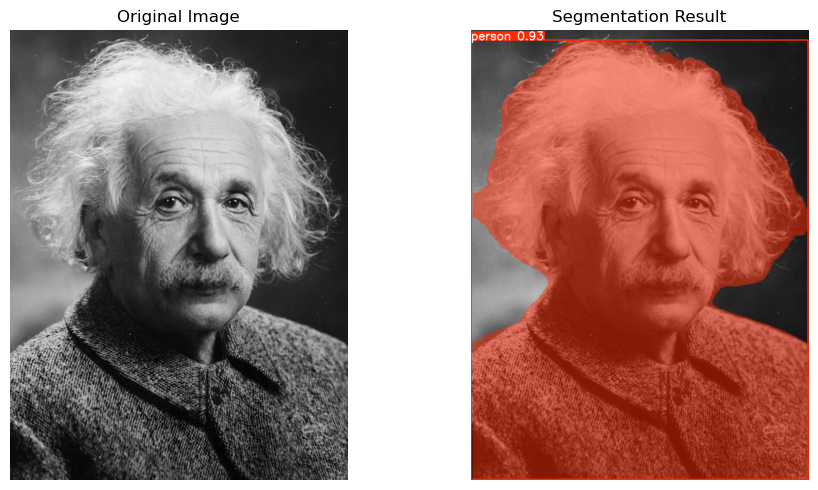

Number of objects detected: 1


In [6]:
# Demonstrate extracting and visualizing a mask
# Use Einstein image for a clearer example
einstein_path = "../images/yolo_einstein_head.jpg"
einstein_bgr = cv2.imread(einstein_path)
einstein_rgb = cv2.cvtColor(einstein_bgr, cv2.COLOR_BGR2RGB)

# Run segmentation
einstein_results = seg_model(einstein_rgb, conf=0.3)
einstein_result = einstein_results[0]

# Show default visualization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(einstein_rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(einstein_result.plot())
plt.title("Segmentation Result")
plt.axis("off")

plt.tight_layout()
plt.show()

print(f"Number of objects detected: {len(einstein_result.boxes)}")

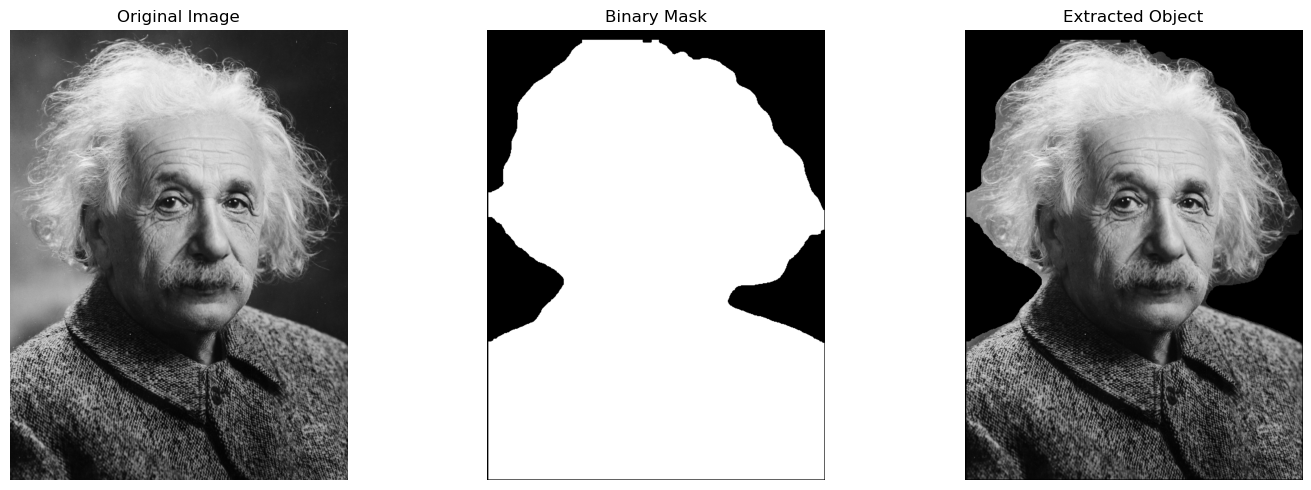

In [7]:
# Extract and visualize the binary mask
if einstein_result.masks is not None and len(einstein_result.masks) > 0:
    # Extract mask for the first detected object
    binary_mask = extract_segmentation_mask(einstein_result, 0)
    
    # Visualize the mask
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(einstein_rgb)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    # Binary mask
    axes[1].imshow(binary_mask, cmap="gray")
    axes[1].set_title("Binary Mask")
    axes[1].axis("off")
    
    # Masked image (object only)
    masked_img = einstein_rgb.copy()
    masked_img[~binary_mask] = 0  # Set background to black
    axes[2].imshow(masked_img)
    axes[2].set_title("Extracted Object")
    axes[2].axis("off")
    
    plt.tight_layout()
    plt.show()
else:
    print("No masks detected. Try with a different image or lower confidence threshold.")

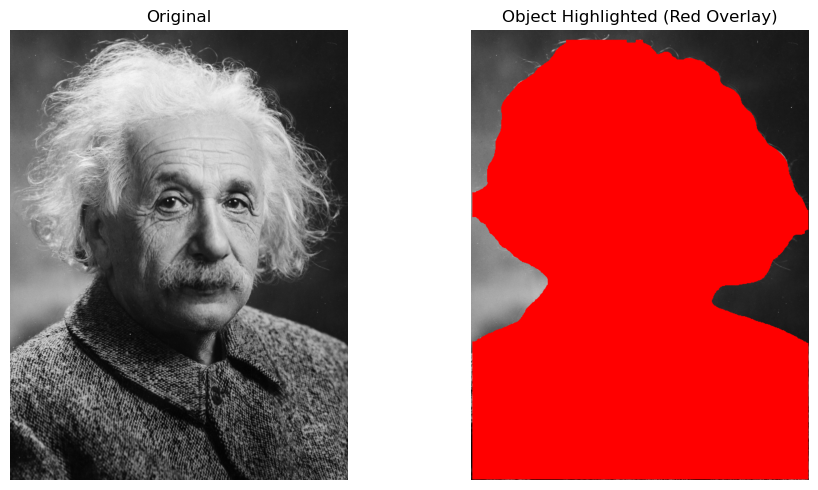

In [8]:
# Demonstrate mask overlay: tint the detected object in red
if einstein_result.masks is not None and len(einstein_result.masks) > 0:
    overlay = einstein_rgb.copy()
    overlay[binary_mask] = [255, 0, 0]  # Set object pixels to red
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(einstein_rgb)
    plt.title("Original")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Object Highlighted (Red Overlay)")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

## Exercise: Pixelate a Person Using a Segmentation Mask

In this exercise, you will:
1. Detect a person in an image
2. Build a binary mask for that person
3. Pixelate either the person or the background

This technique is commonly used for **privacy protection** and **data anonymization**.

In [9]:
# Exercise: Pixelate a person using a segmentation mask

# Load an image with people (beach scene or traffic)
image_path = "../images/yolo_beach_scene.jpg"
img_bgr = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Run segmentation
seg_model = YOLO("yolo11n-seg.pt")
results = seg_model(img_rgb, conf=0.25)
result = results[0]

# TODO: Find the class ID for 'person' in result.names
# Hint: result.names is a dictionary like {0: 'person', 1: 'bicycle', ...}
# Hint: Loop through result.names.items() and check for 'person'

# TODO: Find the first detection that corresponds to a person
# Hint: Loop through result.boxes and check if int(box.cls) matches the person class ID

# TODO: Build a binary mask for that person
# Hint: Use extract_segmentation_mask(result, object_index=person_index)

# TODO: Create pixelated variants
# Hint: You'll need a pixelate() function (define one or use cv2.resize with INTER_NEAREST)
# Hint: Use boolean indexing with the mask: result_img[person_mask] = pixelated[person_mask]

# TODO: Plot results in a 2x2 grid showing:
# - Original image
# - Fully pixelated
# - Pixelated background (clear person)
# - Pixelated person (clear background)

pass  # Remove this line when you complete the TODOs


0: 448x640 10 persons, 3 kites, 160.0ms
Speed: 1.4ms preprocess, 160.0ms inference, 8.0ms postprocess per image at shape (1, 3, 448, 640)


**Use cases for mask-based pixelation:**

- **Privacy protection**: Anonymize faces or people in public datasets
- **Content moderation**: Blur sensitive content automatically
- **Data compliance**: Meet GDPR or other privacy regulations
- **Creative effects**: Highlight subjects by blurring backgrounds

## What Is Pose Estimation?

Pose estimation detects human figures and identifies key body points (keypoints). These keypoints typically include:

- **Face**: Nose, eyes, ears
- **Upper body**: Shoulders, elbows, wrists
- **Lower body**: Hips, knees, ankles

### What the Model Outputs

For each detected person:
- **Bounding box**: Location of the person
- **Keypoints**: (x, y) coordinates for each body point
- **Confidence**: How certain the model is about each keypoint

### Applications

- **Fitness tracking**: Analyze exercise form
- **Sports analytics**: Track athlete movements
- **Human-computer interaction**: Gesture recognition
- **Animation**: Motion capture for games and movies
- **Surveillance**: Detect abnormal behavior

## Pose Estimation with YOLO11

Let's load a pose estimation model and run it on yoga images.

In [10]:
# Load YOLO11 pose estimation model
pose_model = YOLO("yolo11n-pose.pt")

print(f"Pose model loaded: {pose_model.model_name}")

Pose model loaded: yolo11n-pose.pt



0: 640x416 1 person, 80.3ms
Speed: 1.7ms preprocess, 80.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 416)


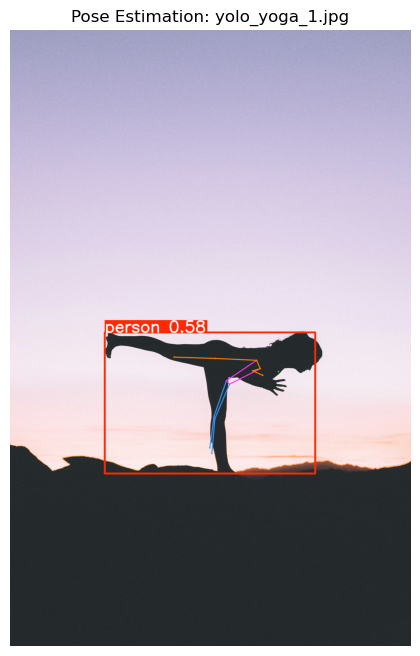


0: 448x640 5 persons, 80.5ms
Speed: 1.5ms preprocess, 80.5ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


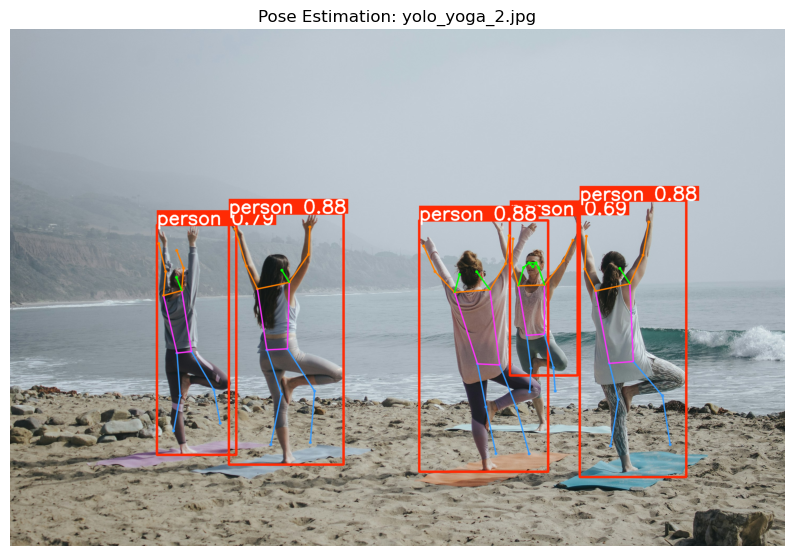

In [11]:
# Run pose estimation on yoga images
yoga_images = [
    "../images/yolo_yoga_1.jpg",
    "../images/yolo_yoga_2.jpg",
]

for path in yoga_images:
    if not os.path.exists(path):
        print(f"Warning: {path} not found. Run 07_intro_to_ultralytics.ipynb first.")
        continue
    
    img_bgr = cv2.imread(path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    results = pose_model(img_rgb)
    r = results[0]
    
    plt.figure(figsize=(10, 8))
    plt.imshow(r.plot())
    plt.title(f"Pose Estimation: {os.path.basename(path)}")
    plt.axis("off")
    plt.show()

**What we see:**

- Keypoints drawn as circles on body joints
- Lines (skeleton) connecting related keypoints
- Different colors for different body parts
- Bounding boxes around detected people

In [12]:
# Inspect the keypoints structure
if r.keypoints is not None:
    print("Keypoints data structure:")
    print(f"  Shape: {r.keypoints.data.shape}")
    print(f"  Interpretation: (num_people, num_keypoints, coordinates)")
    print(f"  Coordinates: [x, y, confidence] for each keypoint")
    
    if r.keypoints.conf is not None:
        print(f"\nKeypoint confidences shape: {r.keypoints.conf.shape}")
        print(f"  Interpretation: (num_people, num_keypoints)")
        
        # Show confidence for first person
        if len(r.keypoints.conf) > 0:
            first_person_conf = r.keypoints.conf[0].cpu().numpy()
            print(f"\nFirst person keypoint confidences:")
            print(f"  Mean: {np.mean(first_person_conf):.3f}")
            print(f"  Min: {np.min(first_person_conf):.3f}")
            print(f"  Max: {np.max(first_person_conf):.3f}")
else:
    print("No keypoints detected.")

Keypoints data structure:
  Shape: torch.Size([5, 17, 3])
  Interpretation: (num_people, num_keypoints, coordinates)
  Coordinates: [x, y, confidence] for each keypoint

Keypoint confidences shape: torch.Size([5, 17])
  Interpretation: (num_people, num_keypoints)

First person keypoint confidences:
  Mean: 0.799
  Min: 0.075
  Max: 1.000


### Exercise: Explore Keypoints on Yoga Images

Analyze keypoint detection results by computing statistics on the model's confidence for each person.

In [13]:
# Exercise: Analyze keypoints on yoga images

def summarize_pose_results(result):
    """
    Print a short summary of pose estimation results:
    - Number of people detected
    - Average keypoint confidence per person
    """
    if result.keypoints is None:
        print("No keypoints found.")
        return
    
    # TODO: Extract keypoint confidence tensor
    # Hint: result.keypoints.conf has shape (num_people, num_keypoints)
    
    # TODO: Compute average confidence per person
    # Hint: Use .mean(axis=1) to average across keypoints for each person
    # Hint: Convert to numpy with .cpu().numpy()
    
    # TODO: Print a short summary
    # Hint: Print the number of people and average confidence for each
    
    pass  # Remove this line when you complete the TODOs

# Test on yoga images
for path in yoga_images:
    if not os.path.exists(path):
        continue
    
    img_bgr = cv2.imread(path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    results = pose_model(img_rgb)
    r = results[0]
    
    print(f"\n=== {os.path.basename(path)} ===")
    summarize_pose_results(r)


0: 640x416 1 person, 73.8ms
Speed: 1.7ms preprocess, 73.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 416)

=== yolo_yoga_1.jpg ===

0: 448x640 5 persons, 77.4ms
Speed: 1.5ms preprocess, 77.4ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)

=== yolo_yoga_2.jpg ===


## Recap

### Key Takeaways

- **Instance Segmentation** provides pixel-level masks for each object, not just bounding boxes
- **Binary masks** (0/1 arrays) can be used to isolate objects, blur regions, or anonymize content
- **Pose Estimation** detects human keypoints (joints) and their connections (skeleton)
- **Keypoint confidence** tells us how certain the model is about each body joint
- **Ultralytics API** is consistent: `YOLO("yolo11n-seg.pt")` for segmentation, `YOLO("yolo11n-pose.pt")` for pose
- **Applications**: Privacy protection, content moderation, fitness tracking, sports analytics, motion capture